In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
latest_date = session.query(func.max(Measurement.date)).scalar()
latest_date

'2017-08-23'

<Figure size 1000x600 with 0 Axes>

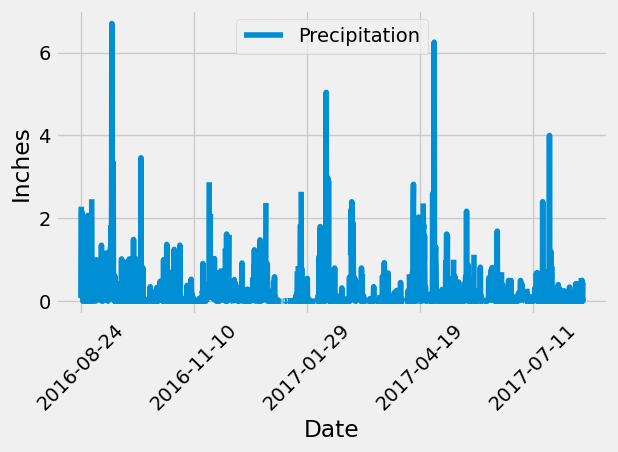

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
from datetime import datetime, timedelta

max_date = session.query(func.max(Measurement.date)).scalar()
max_date = datetime.strptime(max_date, '%Y-%m-%d')

one_year_ago = max_date - timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values(by='Date')
df = df.sort_values(by='Date')
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
df.plot(x='Date', y='Precipitation', kind='line', label='Precipitation', rot=45)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()
summary_statistics

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
from sqlalchemy import func, distinct

total_stations = session.query(func.count(distinct(Measurement.station))).scalar()

print(f'Total number of stations in the dataset: {total_stations}')

Total number of stations in the dataset: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('station_count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

for station, count in active_stations:
    print(f'Station: {station}, Count: {count}')

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Identify the most active station
most_active_station = active_stations[0][0]  # Assuming the first station is the most active

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs).label('min_temp'),
                                  func.max(Measurement.tobs).label('max_temp'),
                                  func.avg(Measurement.tobs).label('avg_temp')).\
    filter(Measurement.station == most_active_station).first()

# Print the results
min_temp, max_temp, avg_temp = temperature_stats
print(f'Most Active Station ID: {most_active_station}')
print(f'Lowest Temperature: {min_temp}°F')
print(f'Highest Temperature: {max_temp}°F')
print(f'Average Temperature: {round(avg_temp, 2)}°F')



Most Active Station ID: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


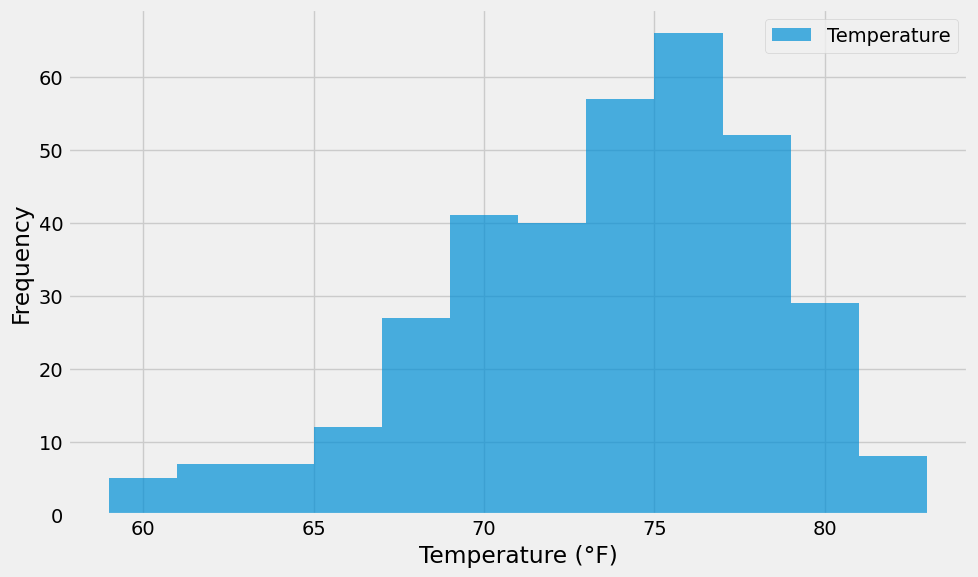

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_date = session.query(func.max(Measurement.date)).scalar()
max_date = datetime.strptime(max_date, '%Y-%m-%d')
one_year_ago = max_date - timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
temperature_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station, Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_results, columns=['Date', 'Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['Temperature'], bins=12, label='Temperature', alpha=0.7)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()